# Libraries and Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/TurbofanDegradationPHM2

/content/drive/MyDrive/TurbofanDegradationPHM2


In [4]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
 

In [5]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
# Loading the Data and Setting the Index
# Load train data
df = pd.read_csv("train.txt", delim_whitespace=True, header=None)
test_data = pd.read_csv("test.txt", delim_whitespace=True, header=None)

# Assign column names
columns = ['unit', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
df.columns = columns
test_data.columns = columns

<ipython-input-7-3c27fccdc427>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("train.txt", delim_whitespace=True, header=None)
<ipython-input-7-3c27fccdc427>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv("test.txt", delim_whitespace=True, header=None)


## Creating Remaining Useful Life Time

Each engine in the training dataset starts operating at cycle 1 and degrades over time until it reaches failure. The goal is to predict how many cycles an engine has left before it fails.

Compute RUL for each row: ***RUL = {max_time} - {current_time}***
where:

*  **max_time** : is the cycle number at failure for that engine.
*   **current_time** : is the cycle number of a particular row

In [8]:
# Compute Remaining Useful Life (RUL)
rul_values = df.groupby('unit')['time'].max().reset_index()
rul_values.columns = ['unit', 'max_time']
df = df.merge(rul_values, on='unit', how='left')
df['RUL'] = df['max_time'] - df['time']
df.drop(columns=['max_time'], inplace=True)

In [18]:
unit1_df = df[df['unit'] == 1].iloc[:,2:-1]

In [19]:
unit1_df

op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  sensor_3  \
0         10.0047        0.2501          20.0    489.05    604.13   1499.45   
1          0.0015        0.0003         100.0    518.67    642.13   1584.55   
2         34.9986        0.8401          60.0    449.44    555.42   1368.17   
3         20.0031        0.7005           0.0    491.19    607.03   1488.44   
4         42.0041        0.8405          40.0    445.00    549.52   1354.48   
..            ...           ...           ...       ...       ...       ...   
218       35.0073        0.8400          60.0    449.44    556.39   1381.50   
219       35.0027        0.8400          60.0    449.44    556.65   1375.43   
220        0.0008        0.0000         100.0    518.67    643.88   1593.26   
221       20.0003        0.7001           0.0    491.19    608.00   1494.99   
222       34.9992        0.8400          60.0    449.44    556.60   1385.96   

     sensor_4  sensor_5  sensor_6  sensor_7  ...  sensor_12  sensor_13  \
0     1309.95     10.52     15.49    394.88  ...     372.15    2388.13   
1     1403.96     14.62     21.61    553.67  ...     521.81    2388.15   
2     1122.49      5.48      8.00    194.93  ...     183.26    2387.95   
3     1249.18      9.35     13.65    334.82  ...     314.84    2388.07   
4     1124.32      3.91      5.71    138.24  ...     130.44    2387.89   
..        ...       ...       ...       ...  ...        ...        ...   
218   1149.74      5.48      8.00    194.02  ...     182.52    2388.11   
219   1149.45      5.48      8.00    193.96  ...     182.73    2388.15   
220   1425.82     14.62     21.61    551.14  ...     520.04    2388.28   
221   1270.18      9.35     13.66    333.03  ...     313.64    2388.37   
222   1150.47      5.48      8.01    194.41  ...     182.61    2388.18   

     sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0      8120.83     8.6216       0.03        368       2319      100.0   
1      8132.87     8.3907       0.03        391       2388      100.0   
2      8063.84     9.3557       0.02        334       2223      100.0   
3      8052.30     9.2231       0.02        364       2324      100.0   
4      8083.67     9.2986       0.02        330       2212      100.0   
..         ...        ...        ...        ...        ...        ...   
218    8068.10     9.4265       0.02        337       2223      100.0   
219    8068.06     9.4148       0.02        338       2223      100.0   
220    8139.03     8.5363       0.03        394       2388      100.0   
221    8065.53     9.2846       0.03        369       2324      100.0   
222    8070.86     9.4489       0.02        337       2223      100.0   

     sensor_20  sensor_21  
0        28.58    17.1735  
1        38.99    23.3619  
2        14.83     8.8555  
3        24.42    14.7832  
4        10.99     6.4025  
..         ...        ...  
218      14.82     8.7966  
219      14.75     8.8290  
220      38.67    23.0218  
221      24.28    14.5645  
222      14.70     8.6695  

[223 rows x 24 columns]

In [22]:
unit1_df.dropna(axis=0 , inplace = True)

In [23]:
start_date = pd.Timestamp('2022-01-01 00:00:00')

In [28]:
series = TimeSeries.from_times_and_values(
    pd.date_range(start_date , periods=len(unit1_df) , freq = 'D'),
    unit1_df.values
)

In [29]:
df_time = series.pd_dataframe()

In [30]:
df_time

component         0       1      2       3       4        5        6      7  \
time                                                                          
2022-01-01  10.0047  0.2501   20.0  489.05  604.13  1499.45  1309.95  10.52   
2022-01-02   0.0015  0.0003  100.0  518.67  642.13  1584.55  1403.96  14.62   
2022-01-03  34.9986  0.8401   60.0  449.44  555.42  1368.17  1122.49   5.48   
2022-01-04  20.0031  0.7005    0.0  491.19  607.03  1488.44  1249.18   9.35   
2022-01-05  42.0041  0.8405   40.0  445.00  549.52  1354.48  1124.32   3.91   
...             ...     ...    ...     ...     ...      ...      ...    ...   
2022-08-07  35.0073  0.8400   60.0  449.44  556.39  1381.50  1149.74   5.48   
2022-08-08  35.0027  0.8400   60.0  449.44  556.65  1375.43  1149.45   5.48   
2022-08-09   0.0008  0.0000  100.0  518.67  643.88  1593.26  1425.82  14.62   
2022-08-10  20.0003  0.7001    0.0  491.19  608.00  1494.99  1270.18   9.35   
2022-08-11  34.9992  0.8400   60.0  449.44  556.60  1385.96  1150.47   5.48   

component       8       9  ...      14       15       16      17    18     19  \
time                       ...                                                  
2022-01-01  15.49  394.88  ...  372.15  2388.13  8120.83  8.6216  0.03  368.0   
2022-01-02  21.61  553.67  ...  521.81  2388.15  8132.87  8.3907  0.03  391.0   
2022-01-03   8.00  194.93  ...  183.26  2387.95  8063.84  9.3557  0.02  334.0   
2022-01-04  13.65  334.82  ...  314.84  2388.07  8052.30  9.2231  0.02  364.0   
2022-01-05   5.71  138.24  ...  130.44  2387.89  8083.67  9.2986  0.02  330.0   
...           ...     ...  ...     ...      ...      ...     ...   ...    ...   
2022-08-07   8.00  194.02  ...  182.52  2388.11  8068.10  9.4265  0.02  337.0   
2022-08-08   8.00  193.96  ...  182.73  2388.15  8068.06  9.4148  0.02  338.0   
2022-08-09  21.61  551.14  ...  520.04  2388.28  8139.03  8.5363  0.03  394.0   
2022-08-10  13.66  333.03  ...  313.64  2388.37  8065.53  9.2846  0.03  369.0   
2022-08-11   8.01  194.41  ...  182.61  2388.18  8070.86  9.4489  0.02  337.0   

component       20     21     22       23  
time                                       
2022-01-01  2319.0  100.0  28.58  17.1735  
2022-01-02  2388.0  100.0  38.99  23.3619  
2022-01-03  2223.0  100.0  14.83   8.8555  
2022-01-04  2324.0  100.0  24.42  14.7832  
2022-01-05  2212.0  100.0  10.99   6.4025  
...            ...    ...    ...      ...  
2022-08-07  2223.0  100.0  14.82   8.7966  
2022-08-08  2223.0  100.0  14.75   8.8290  
2022-08-09  2388.0  100.0  38.67  23.0218  
2022-08-10  2324.0  100.0  24.28  14.5645  
2022-08-11  2223.0  100.0  14.70   8.6695  

[223 rows x 24 columns]

In [32]:
daily = df_time.groupby(df_time.index.day).mean()

In [33]:
scaler = Scaler()

In [ ]:
# hourly = scaler.fit_transform(hourly)

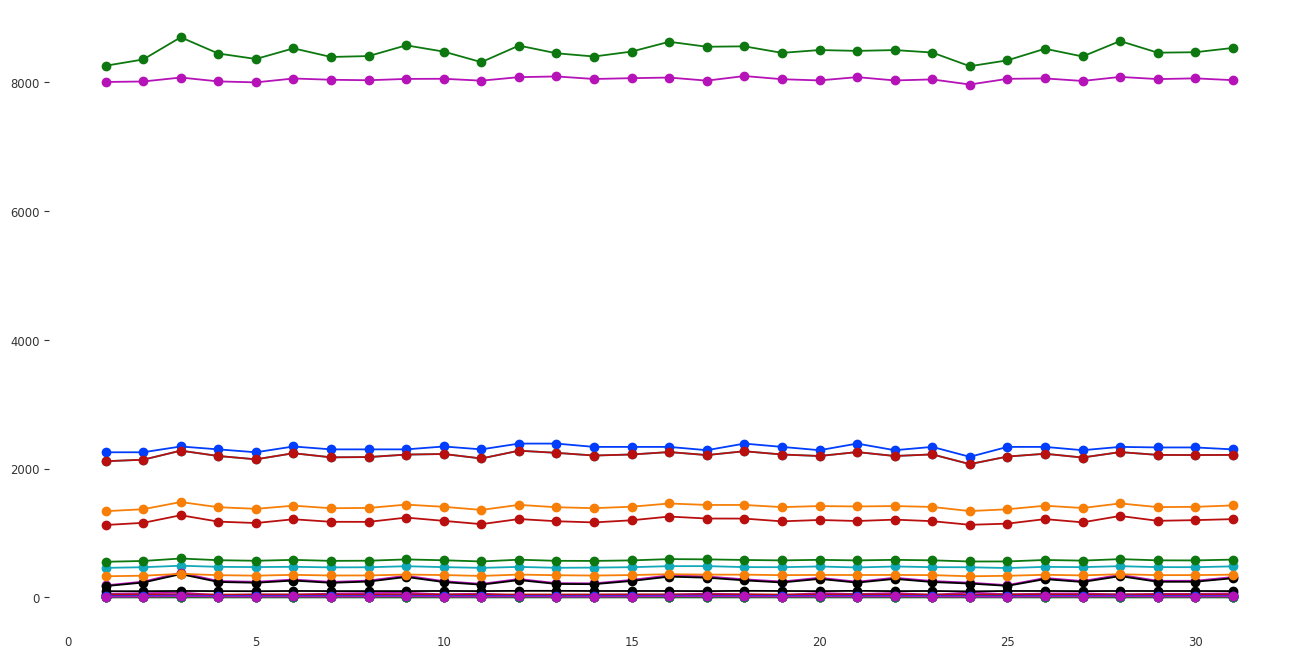

In [34]:
plt.figure(figsize = (16,8))
plt.plot(daily , marker = 'o')
plt.grid()
plt.show()

In [37]:
daily_std = (daily - daily.mean(axis = 0))/daily.std(axis = 0)

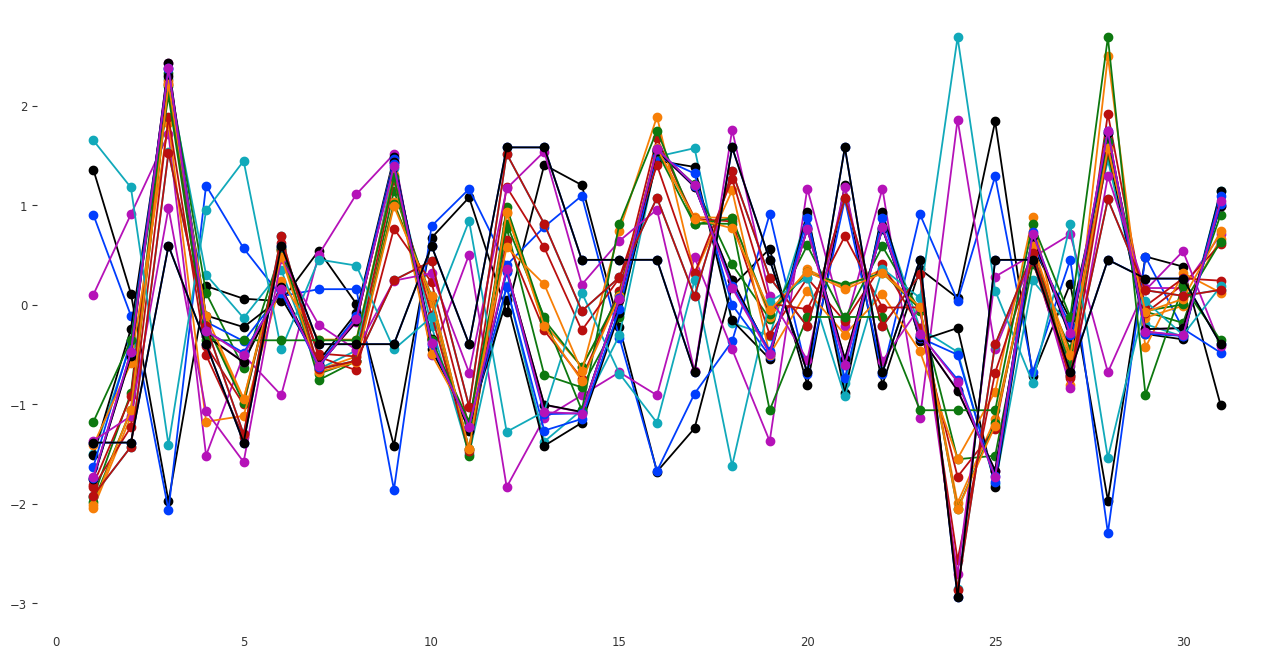

In [38]:
plt.figure(figsize = (16,8))
plt.plot(daily_std.iloc[:,:100] , marker = 'o')
plt.grid()
plt.show()

In [39]:
# Weekly Seasonolity

In [40]:
week = df_time.groupby(df_time.index.day_of_week).mean()

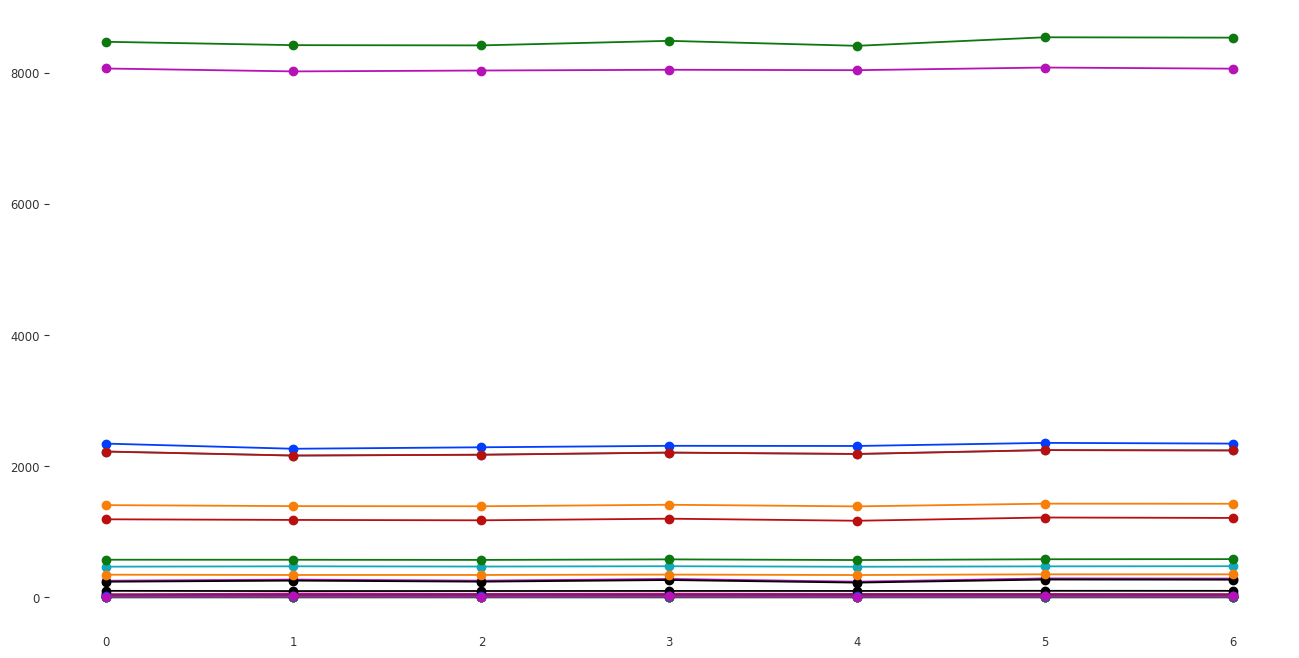

In [41]:
plt.figure(figsize = (16,8))
plt.plot(week , marker = 'o')
plt.grid()
plt.show()

In [42]:
week_std = (week - week.mean(axis = 0))/week.std(axis = 0)

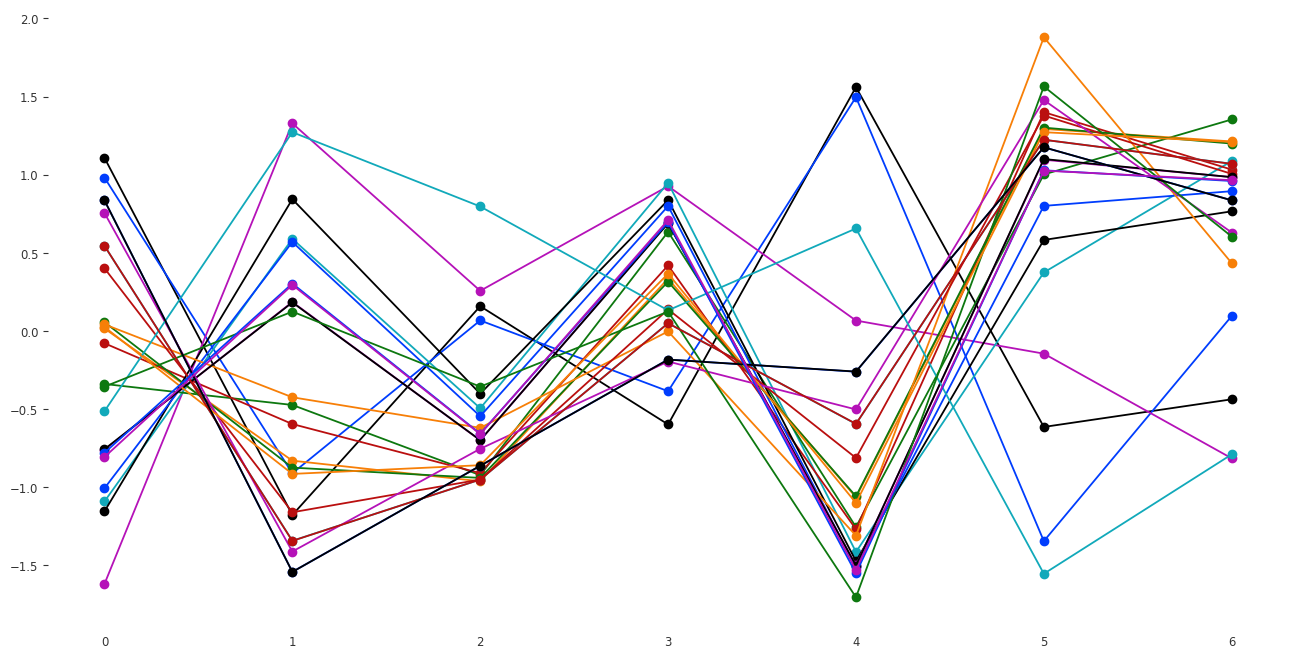

In [43]:
plt.figure(figsize = (16,8))
plt.plot(week_std.iloc[:,:100] , marker = 'o')
plt.grid()
plt.show()

# Exploratory Data Analysis

In [55]:
# For Sensor 1 and operational Measurement 1

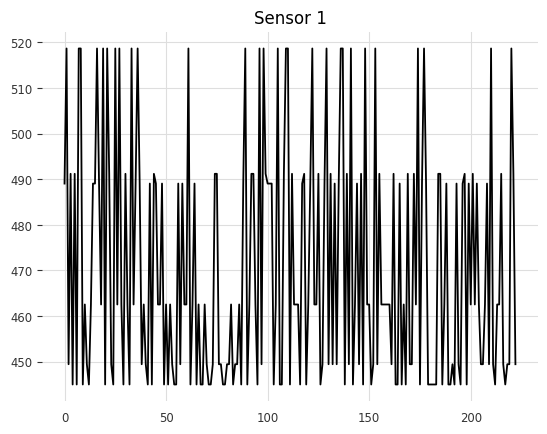

In [44]:
# Daily Closing Price  Plot
unit1_df['sensor_1'].plot(title = 'Sensor 1')
plt.show()

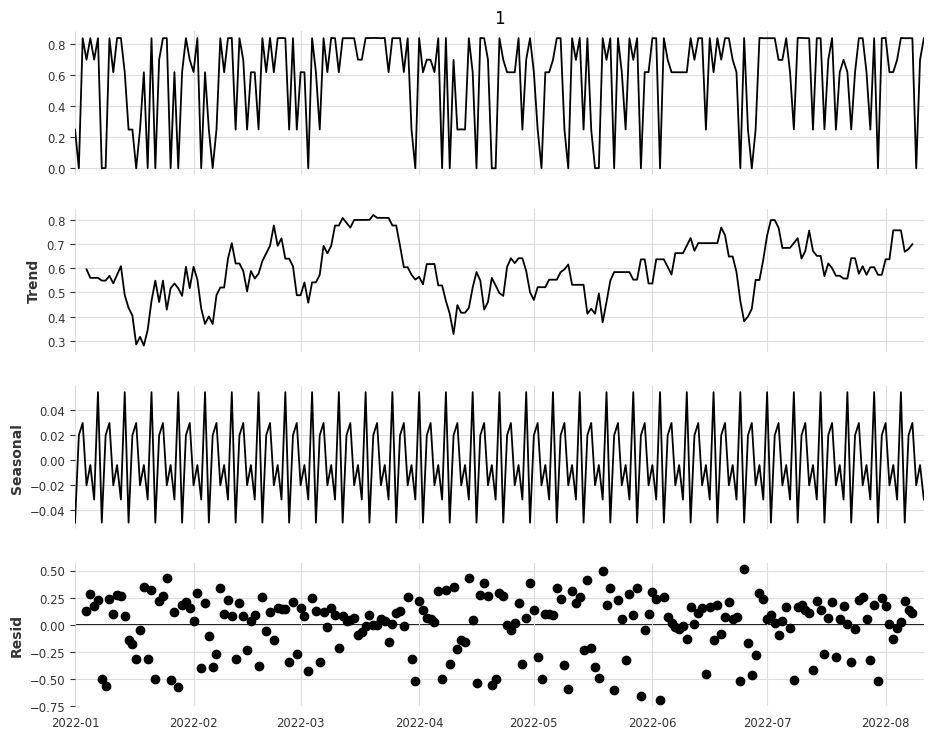

In [54]:
# Seasonal Decomposition Plots for PHP
decomposition = seasonal_decompose(df_time['1'],
                                   model = 'add',
                                   period = 7)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

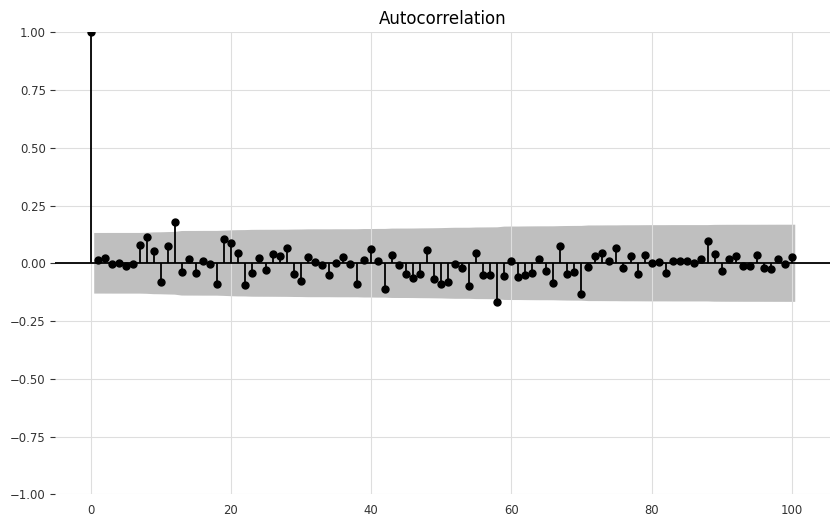

In [56]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df_time['1'], lags = 100, ax = ax)
plt.show()

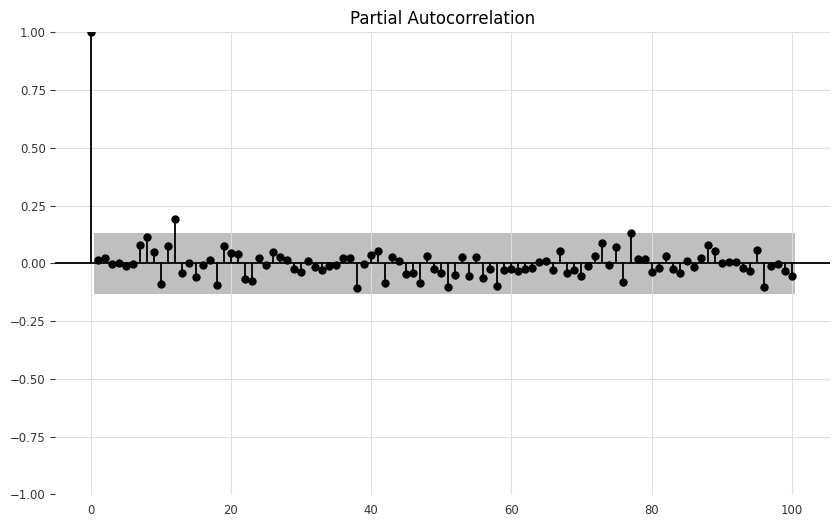

In [57]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df_time['1'], lags = 100, ax = ax)
plt.show()

In [58]:
series = TimeSeries.from_series(df_time)
series

<TimeSeries (DataArray) (time: 223, component: 24, sample: 1)> Size: 43kB
array([[[1.00047e+01],
        [2.50100e-01],
        [2.00000e+01],
        ...,
        [1.00000e+02],
        [2.85800e+01],
        [1.71735e+01]],

       [[1.50000e-03],
        [3.00000e-04],
        [1.00000e+02],
        ...,
        [1.00000e+02],
        [3.89900e+01],
        [2.33619e+01]],

       [[3.49986e+01],
        [8.40100e-01],
        [6.00000e+01],
        ...,
...
        ...,
        [1.00000e+02],
        [3.86700e+01],
        [2.30218e+01]],

       [[2.00003e+01],
        [7.00100e-01],
        [0.00000e+00],
        ...,
        [1.00000e+02],
        [2.42800e+01],
        [1.45645e+01]],

       [[3.49992e+01],
        [8.40000e-01],
        [6.00000e+01],
        ...,
        [1.00000e+02],
        [1.47000e+01],
        [8.66950e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2022-01-01 2022-01-02 ... 2022-08-11
  * component  (component) object 192B '0' '1' '2' '3' ... '20' '21' '22' '23'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [59]:
hour_series = datetime_attribute_timeseries(series , attribute='hour' , one_hot=True)
weekday_series = datetime_attribute_timeseries(hour_series , attribute='weekday' , one_hot=True)

In [60]:
scalar1 = Scaler()

In [61]:
y_transformed = scalar1.fit_transform(series=series)

In [62]:
covariates_transformed = hour_series.stack(weekday_series)

In [63]:
forecasting_horizon = 10
input_chunk_length = 12

In [64]:
model = RNNModel(
    model = 'LSTM',
    input_chunk_length= input_chunk_length,
    n_rnn_layers=2,
    hidden_dim=10,
    dropout=0.1,
    training_length= input_chunk_length+forecasting_horizon,
    optimizer_kwargs = {'lr':0.01},
    random_state=42,
    n_epochs = 10 ,
)

In [65]:
model.fit(y_transformed, future_covariates=covariates_transformed )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K  | train
6 | V               | Linear           | 264    | train
-------------------------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=10, n_rnn_layers=2, dropout=0.1, training_length=22, input_chunk_length=12, optimizer_kwargs={'lr': 0.01}, random_state=42, n_epochs=10)

In [66]:
cv = model.historical_forecasts(
    series = y_transformed,
    future_covariates = covariates_transformed,
    forecast_horizon = forecasting_horizon,
    start = series.shape[0]-400,
    stride = 24,
    retrain = True,
    last_points_only = False,
    # pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0]}
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.6 K  | train
6 | V               | Linear           | 264    | train
-------------------------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [67]:
rmse = []
for i in range(len(cv)):
  predictions = TimeSeries.pd_dataframe(scalar1.inverse_transform(cv[i]))
  start = predictions.index.min()
  end = predictions.index.max()
  actuals = df_time[start:end]
  rmse.append(np.sqrt(mean_squared_error(actuals , predictions)))
print('RMSE : ', np.mean(rmse))

RMSE :  98.92605763050109


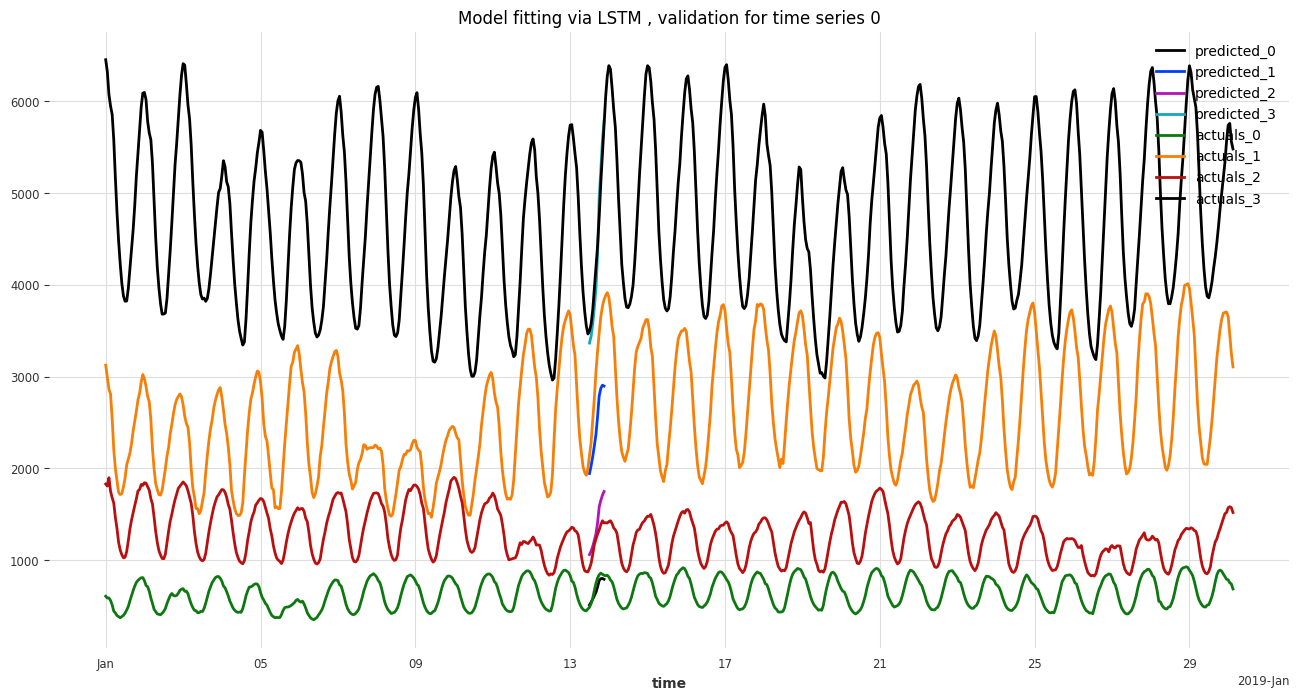

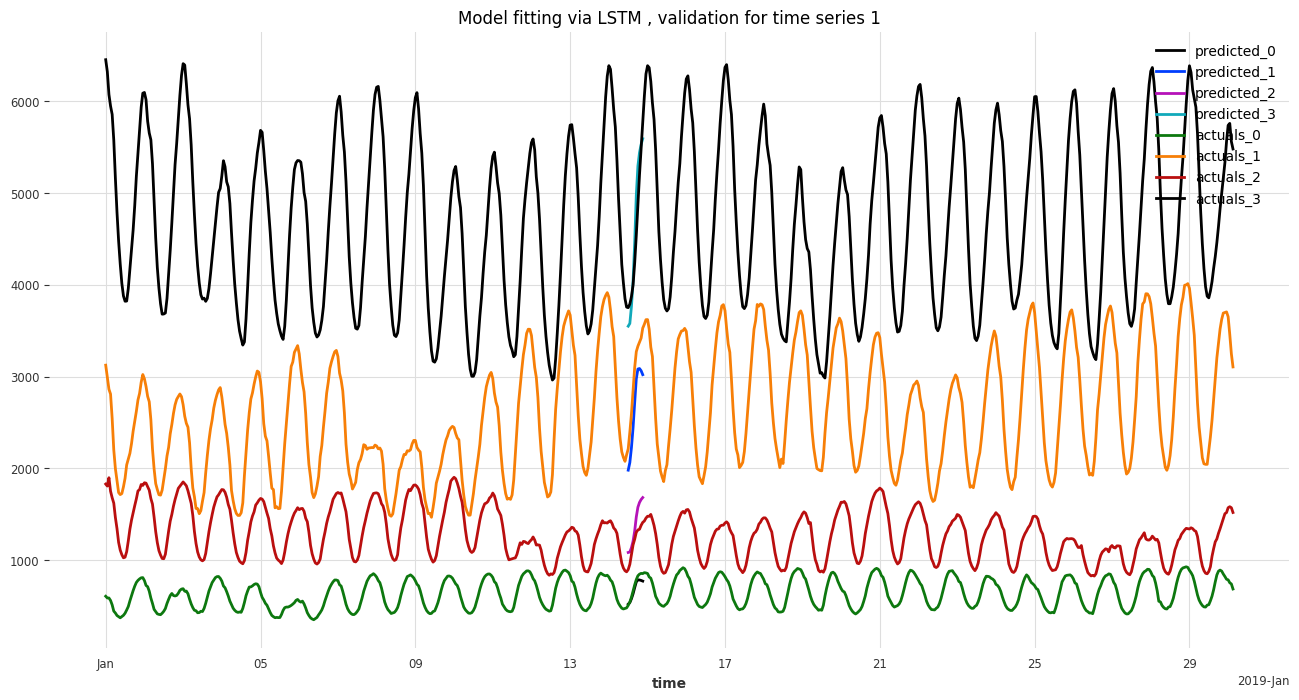

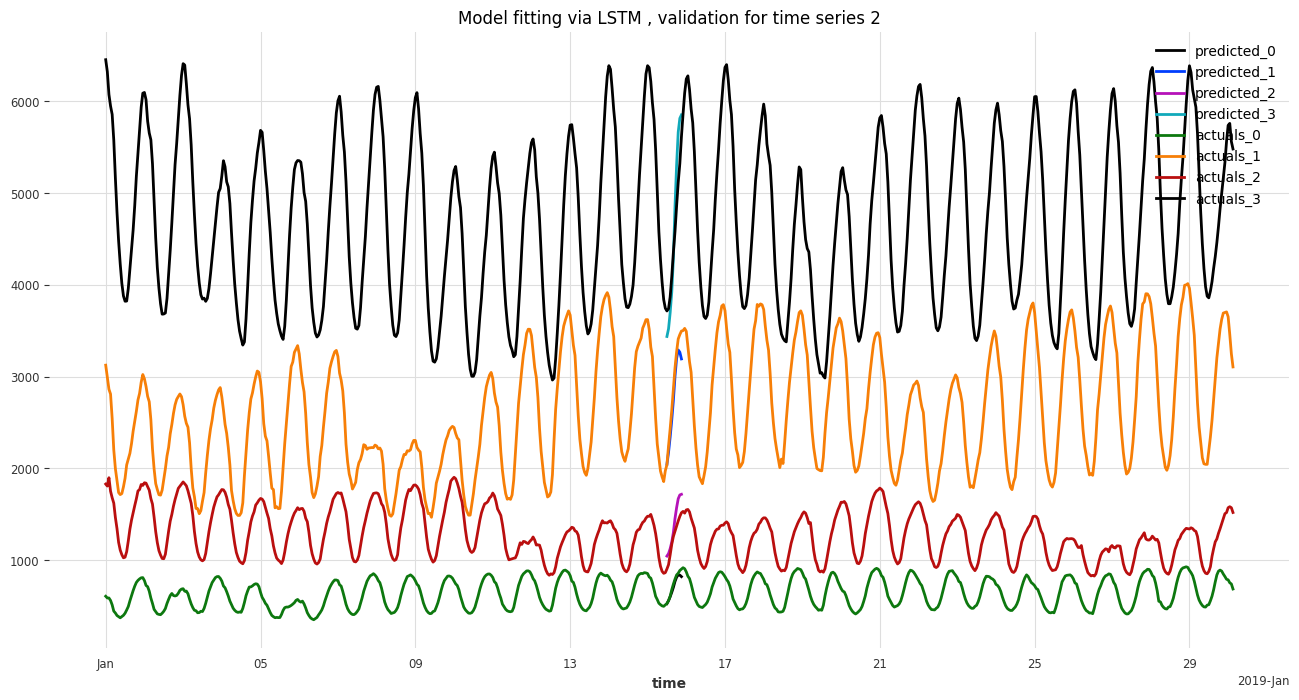

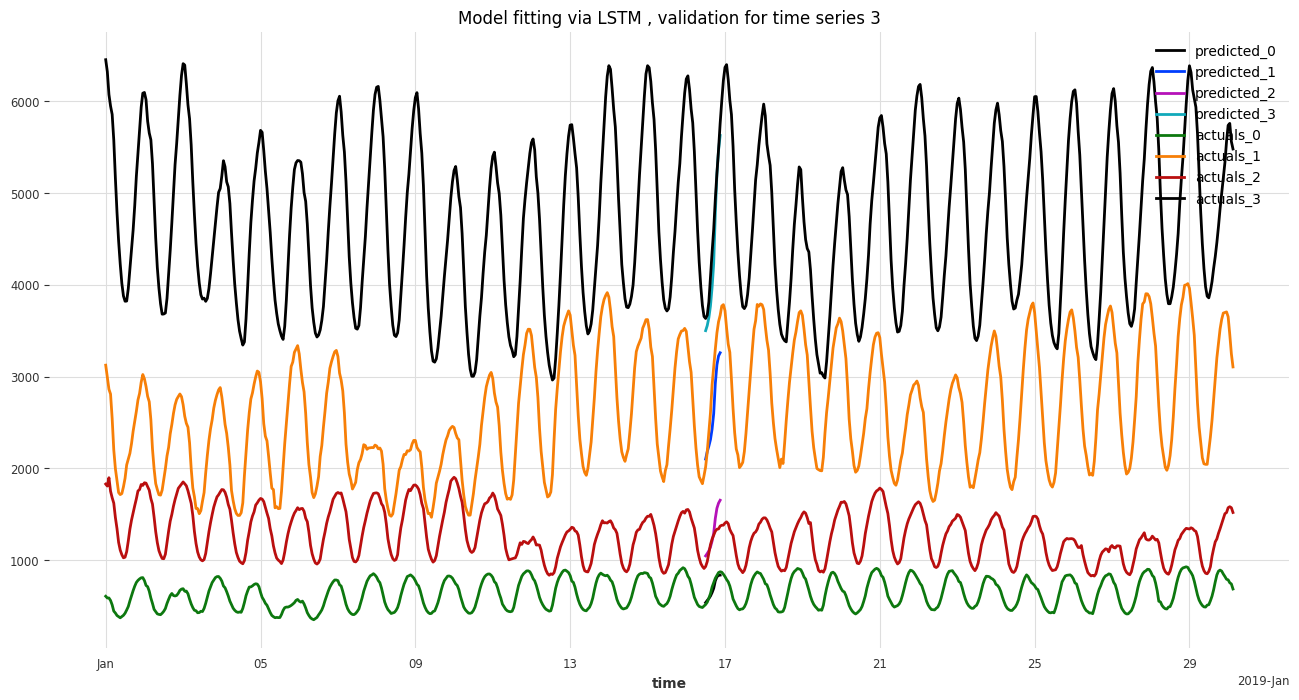

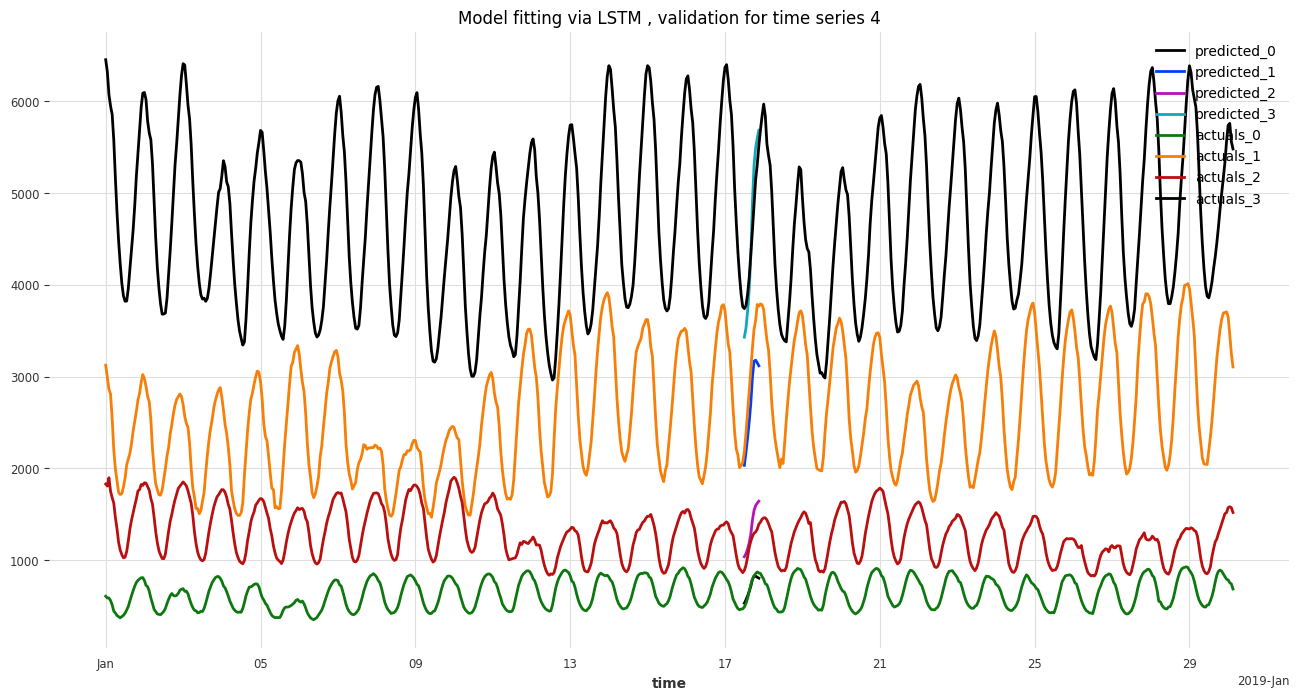

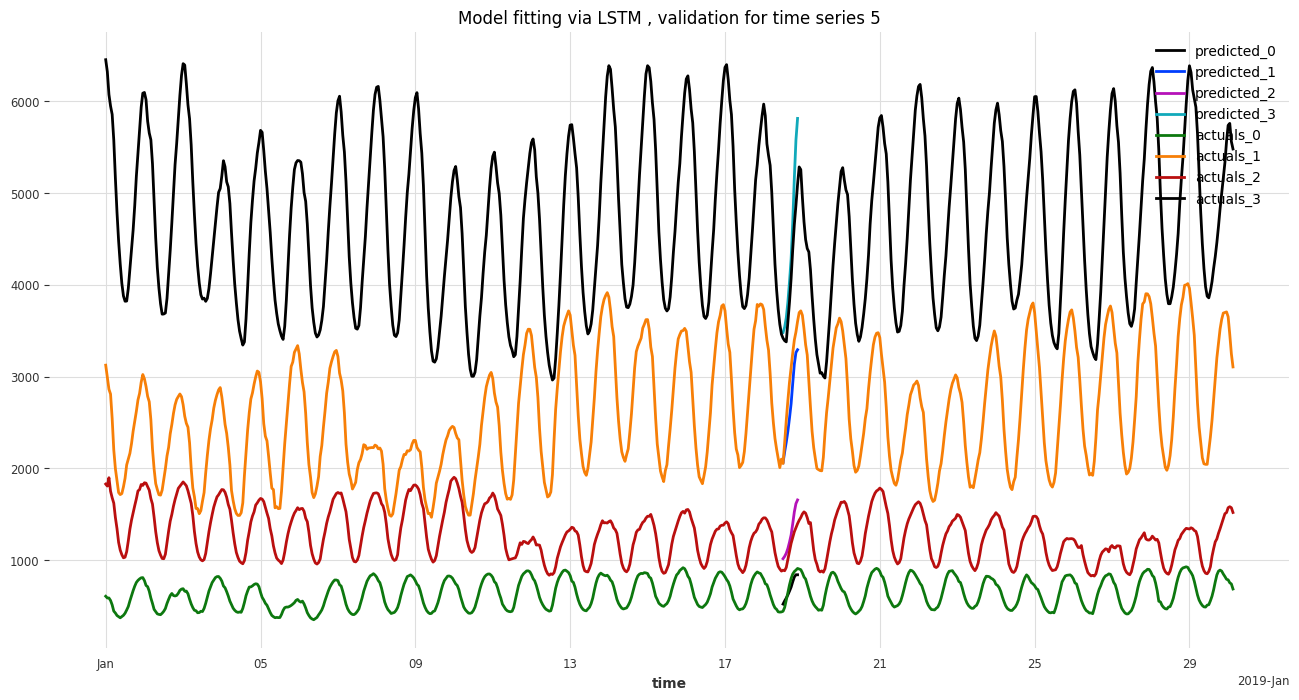

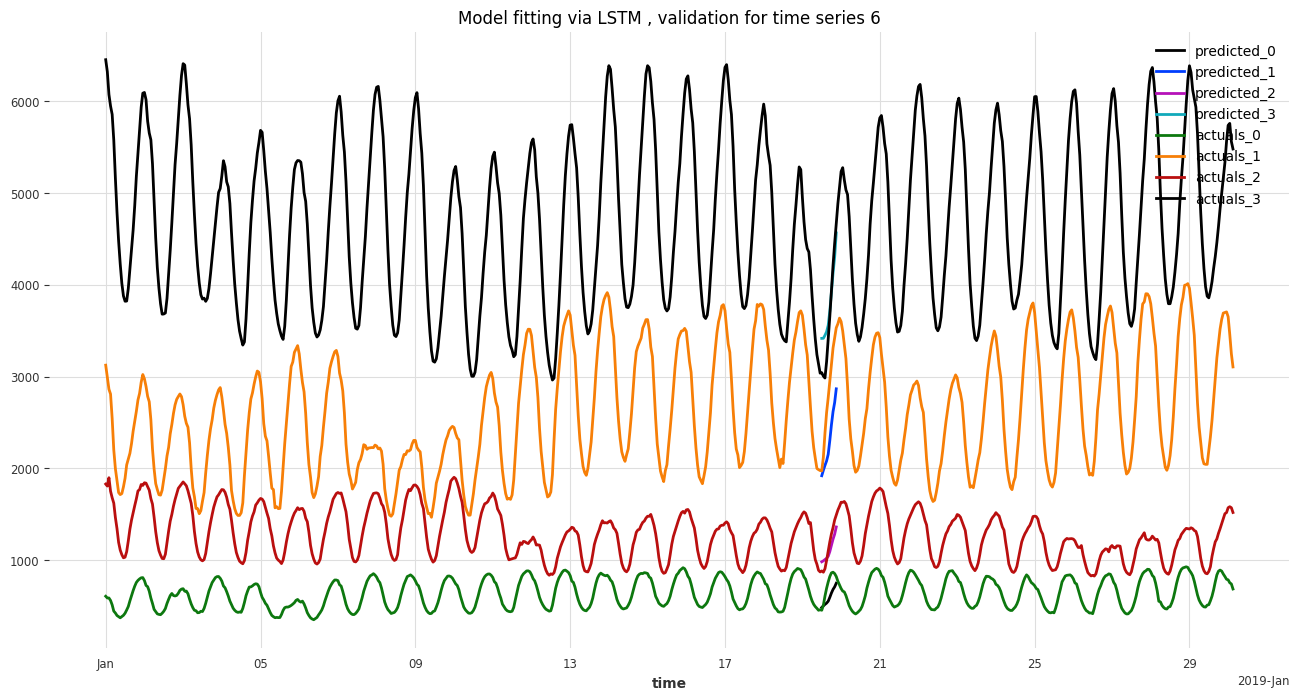

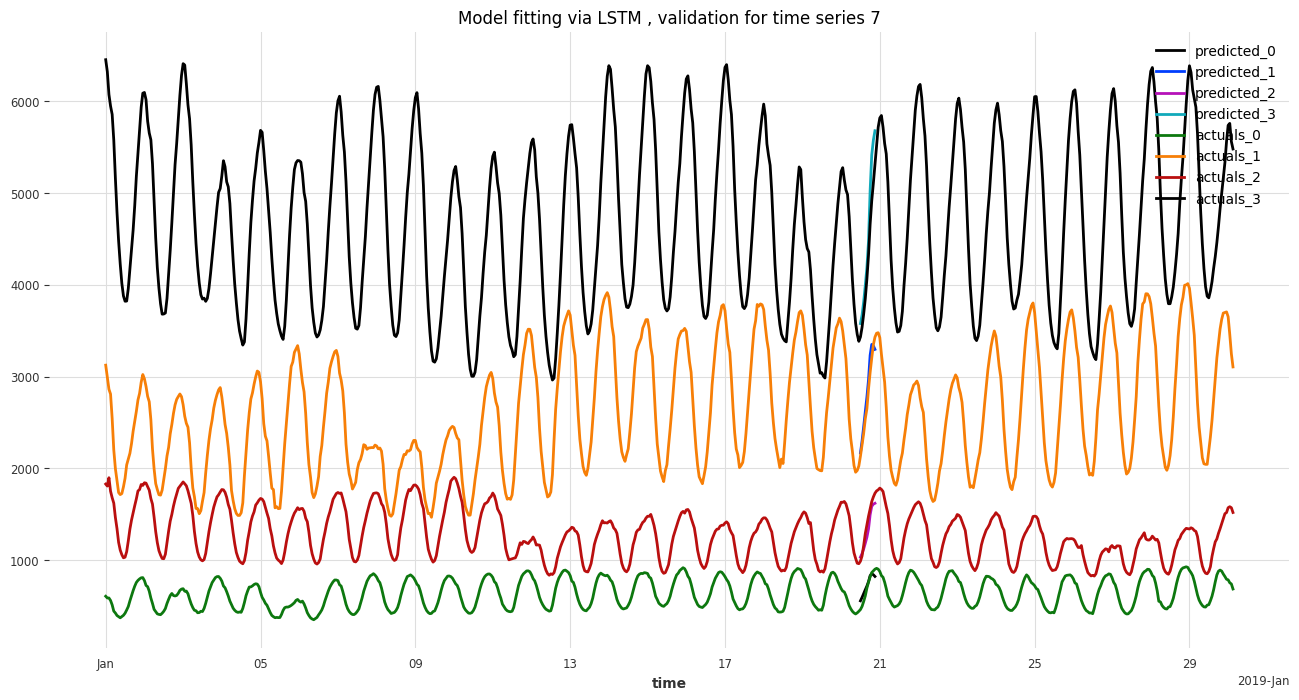

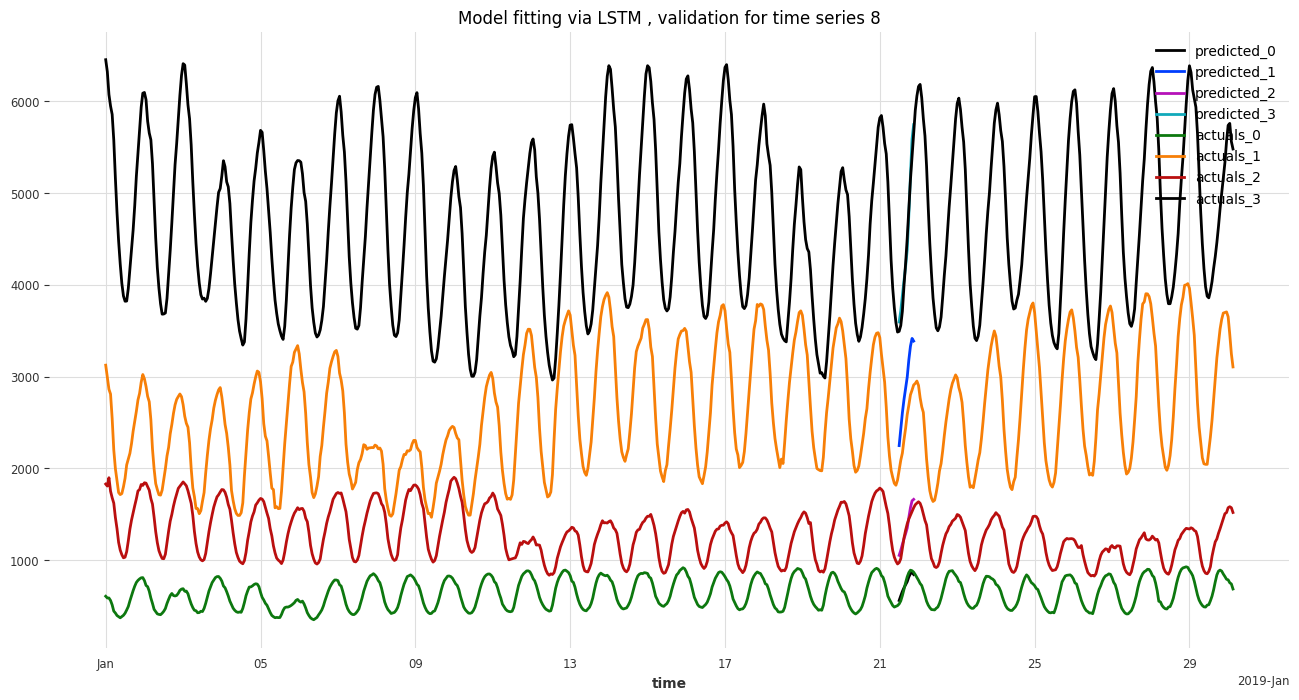

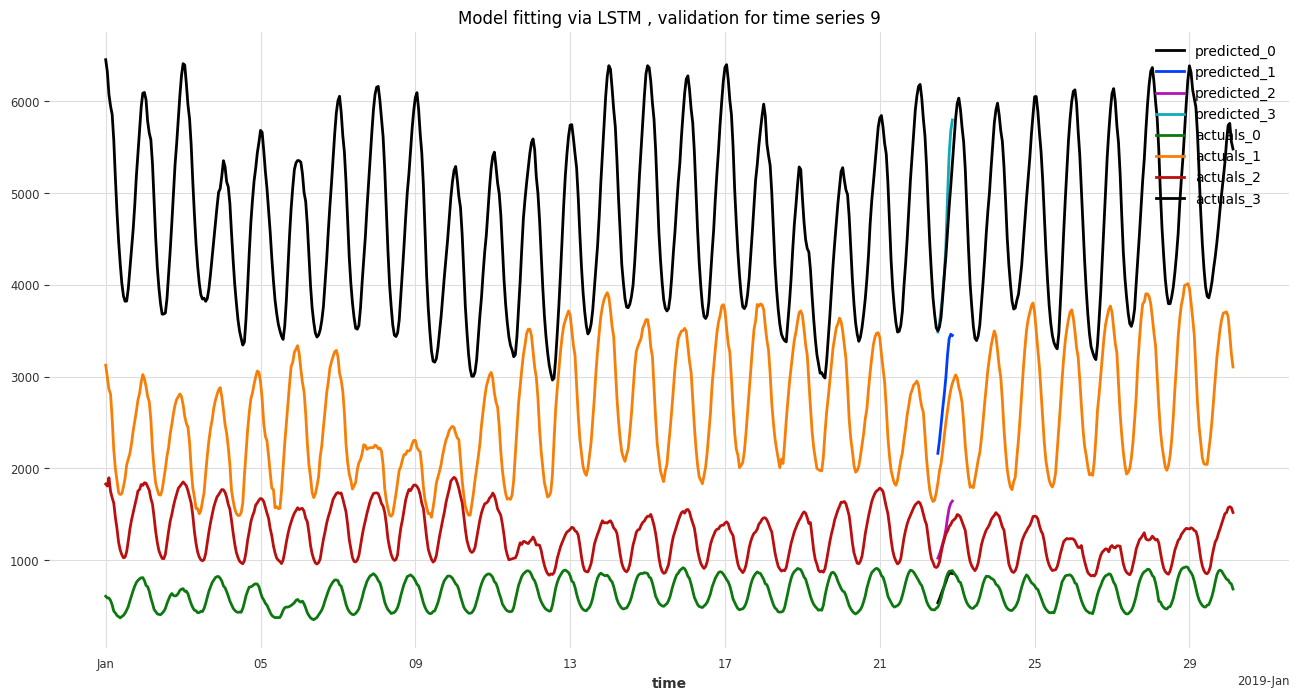

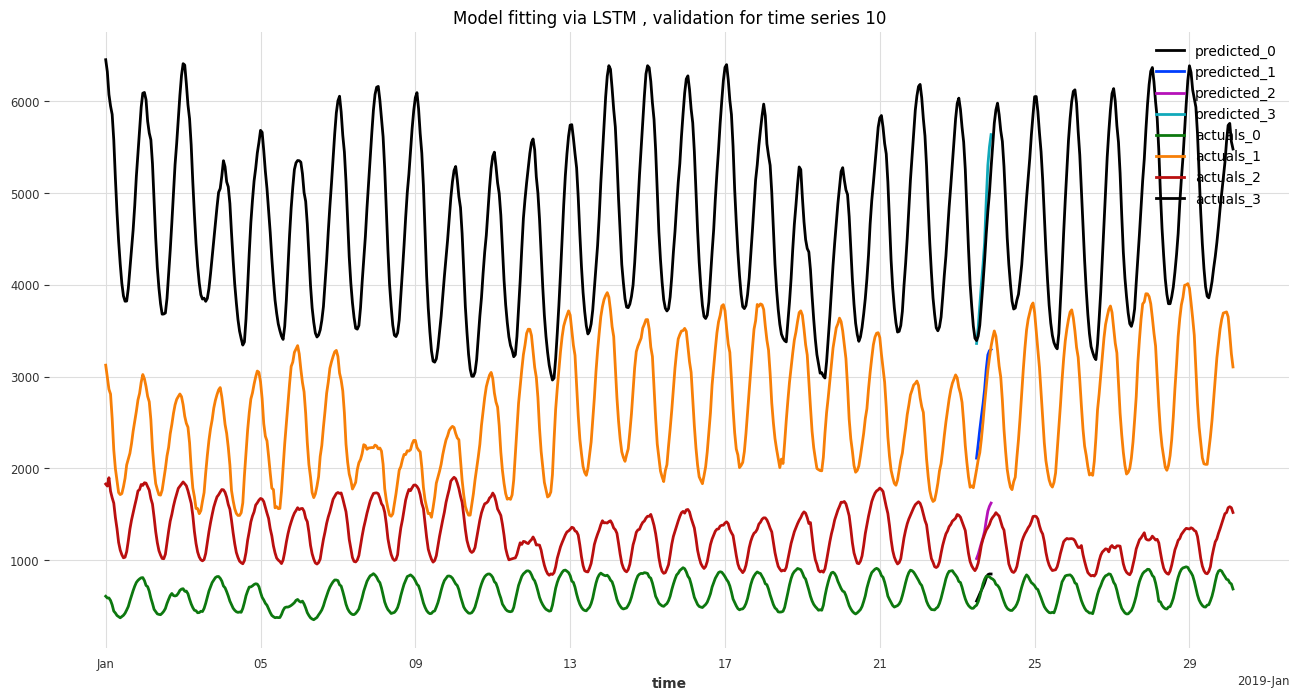

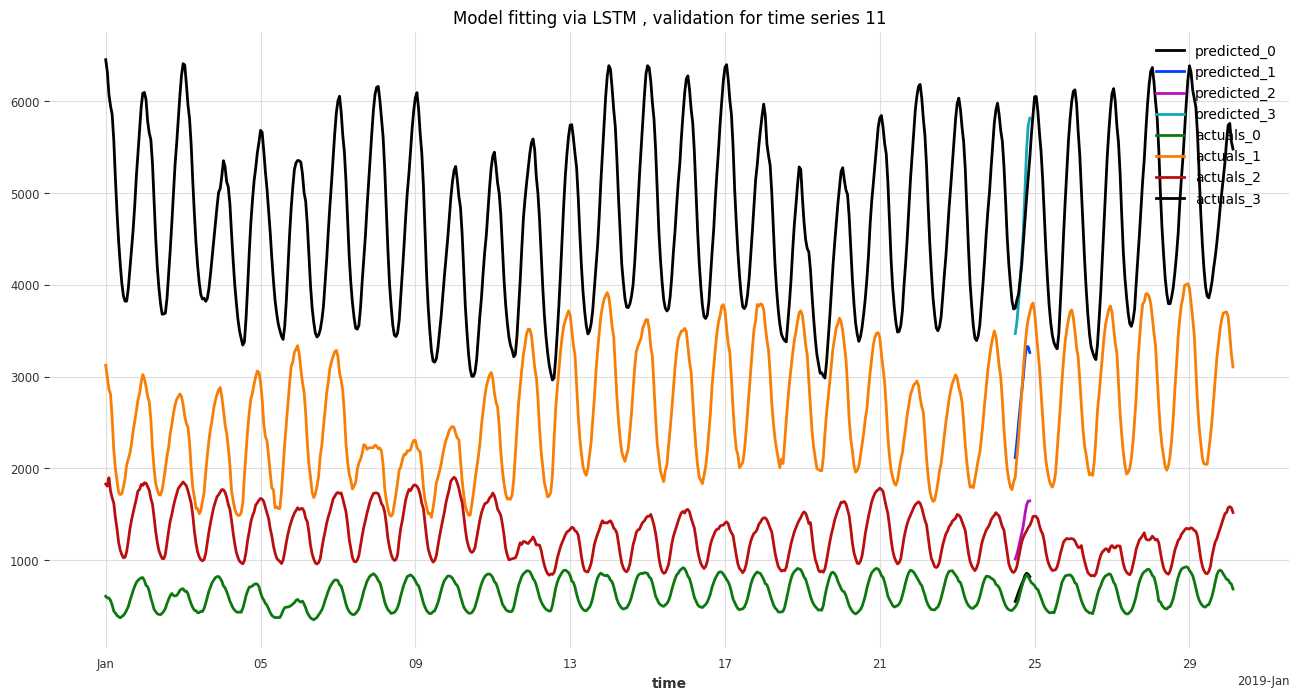

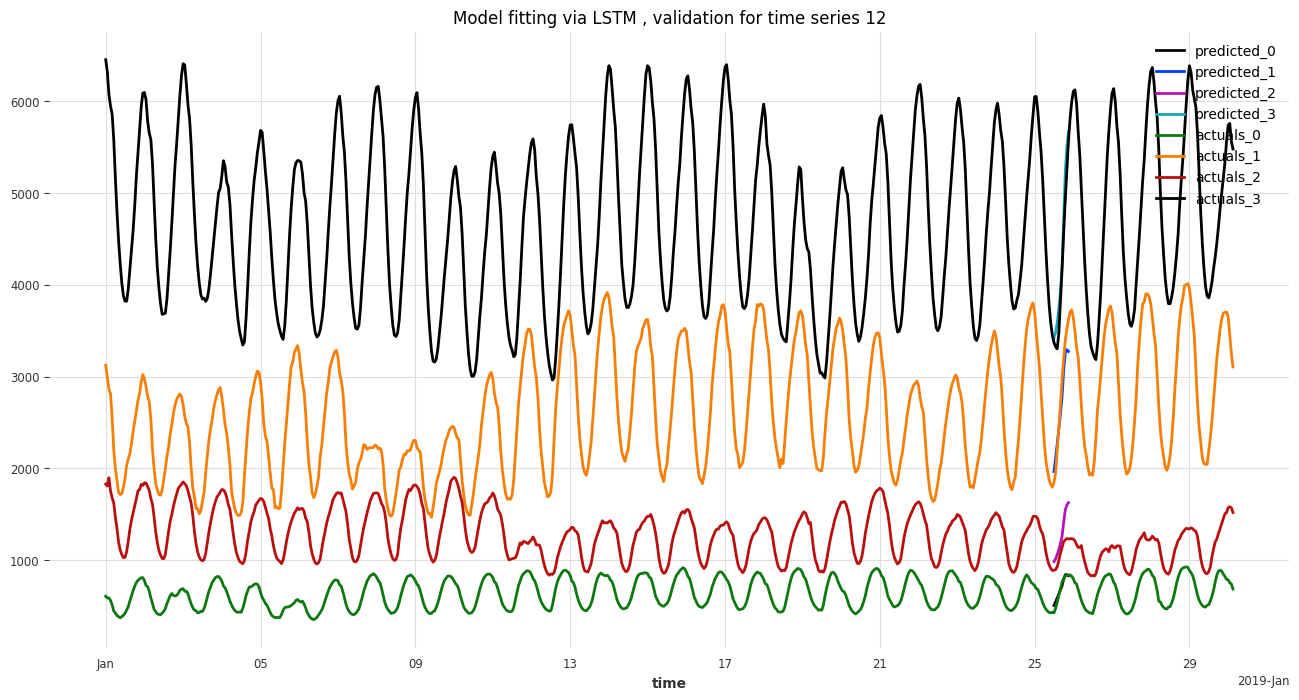

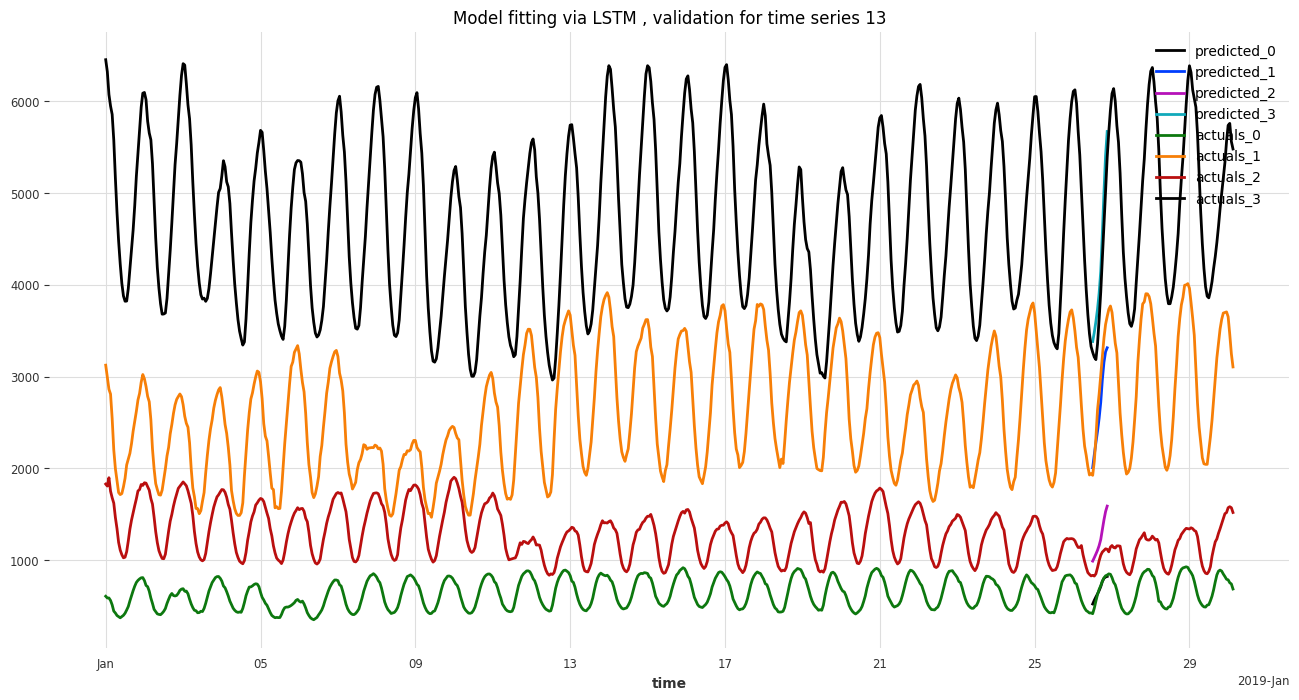

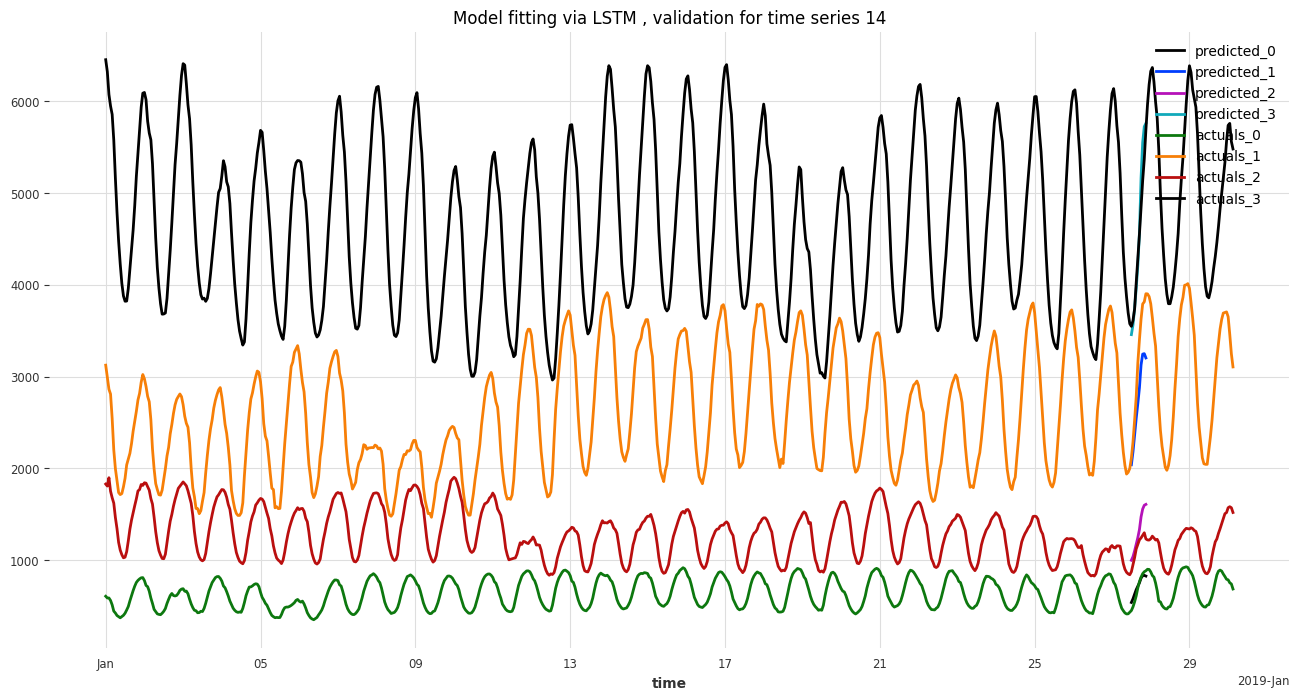

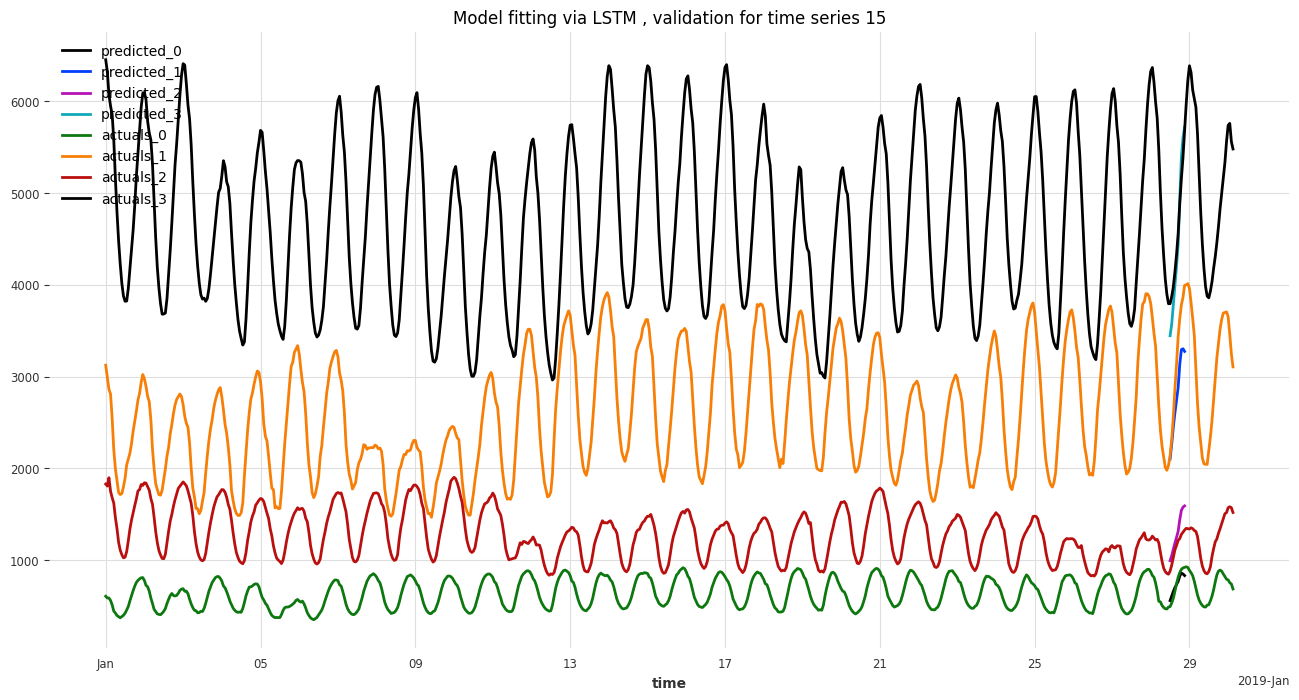

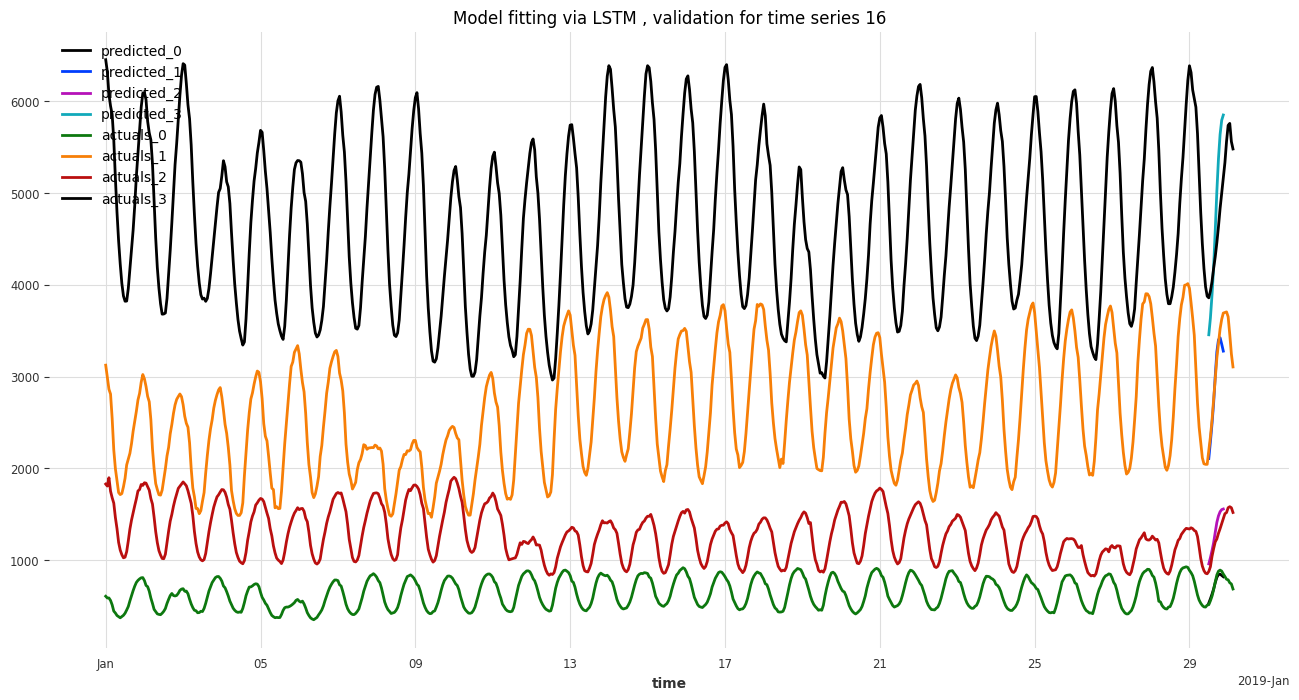

In [ ]:
for i in range(len(cv)):
  plt.figure(figsize = (16,8))
  scalar1.inverse_transform(cv[i]).plot(max_nr_components=4 , label = 'predicted')
  series.plot(max_nr_components=4,label = 'actuals')
  plt.legend()
  plt.title(f"Model fitting via LSTM , validation for time series {i}")

In [81]:
future_time_index = pd.date_range(start = series.end_time()+ pd.Timedelta(days=1) , periods = 48 , freq = 'd')

In [82]:
fut_hour_series = datetime_attribute_timeseries(future_time_index , attribute='hour' , one_hot=True)
fut_weekday_series = datetime_attribute_timeseries(future_time_index , attribute='weekday' , one_hot=True)

In [83]:
fut_series = fut_hour_series.stack(fut_weekday_series)

In [85]:
fut_series = covariates_transformed.append(fut_series)

In [86]:
forecasted = TimeSeries.pd_dataframe(scalar1.inverse_transform(model.predict(n = 48 , future_covariates=fut_series)))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

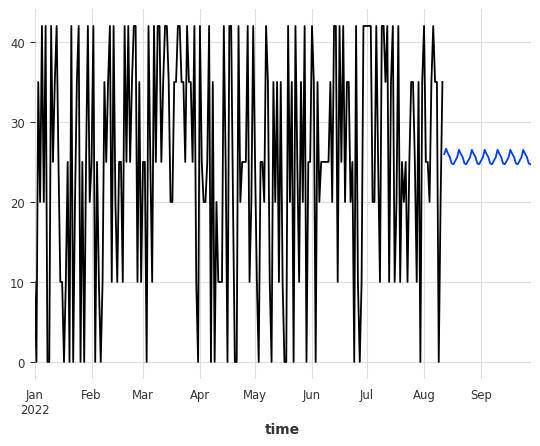

In [97]:
df_time['0'].plot()
forecasted['0'].plot()

# Model Building for Remaining Useful Life Time Estimation

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [100]:
# Select features and target
features = df.drop(columns=['unit', 'time', 'RUL'])
target = df['RUL']

In [101]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

In [102]:
# Train model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

RandomForestRegressor()

In [103]:
# Evaluate
y_pred = model.predict(X_val)
print("RMSE:", mean_squared_error(y_val, y_pred, squared=False))

RMSE: 41.022611969929045


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [105]:
## Deep Learning Based Methods

In [106]:
# Normalize sensor data
feature_columns = [col for col in df.columns if col not in ['unit', 'time', 'RUL']]
scaler = MinMaxScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

In [108]:
## ANN Model

In [118]:
# Function to build models
def build_ann():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(24,)), ## 3 operational Settings + 21 Sensor Measurements
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [119]:
ann_model = build_ann()

In [120]:
ann_model.fit(X_train, y_train , epochs = 10)

Epoch 1/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 21346.7305 - mae: 83.8672
Epoch 2/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5137.4517 - mae: 59.3232
Epoch 3/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4979.3301 - mae: 58.5085
Epoch 4/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4968.1152 - mae: 58.5968
Epoch 5/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4743.5493 - mae: 57.5197
Epoch 6/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4752.4868 - mae: 57.5534
Epoch 7/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4705.4180 - mae: 57.4447
Epoch 8/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4788.4014 - mae: 57.7626
Epoch 9/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4812.6992 - mae: 57.7987
Epoch 10/10
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4706.0317 - mae: 57.3743


In [121]:
# Evaluate
y_pred_ann = ann_model.predict(X_val)
print("RMSE:", mean_squared_error(y_val, y_pred_ann, squared=False))

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 68.37234230482277


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Scoring for ANN model
print("Penalized Score for ANN Model: " , score_calc(ann_model , X_test , y_test))

In [122]:
# Create sequences for time-series modeling
def create_sequences(data, seq_length=50):
    sequences = []
    targets = []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit]
        for i in range(len(unit_data) - seq_length):
            sequences.append(unit_data.iloc[i:i+seq_length][feature_columns].values)
            targets.append(unit_data.iloc[i+seq_length]['RUL'])
    return np.array(sequences), np.array(targets)

In [126]:
seq_length = 50  # Number of past cycles used for prediction
X, y = create_sequences(df, seq_length)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_rnn():
    model = Sequential([
        SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[2])),
        SimpleRNN(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def build_lstm():
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[2])),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [130]:
# Train and evaluate models
def train_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
    return history

In [127]:
# RNN Model Training
rnn_model = build_rnn()
print("Training RNN...")
train_model(rnn_model, X_train, y_train, X_test, y_test)

In [129]:
# LSTM Model Training
lstm_model = build_lstm()
print("Training LSTM...")
train_model(lstm_model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM...
Epoch 1/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - loss: 4190.6284 - mae: 50.5058 - val_loss: 2989.3938 - val_mae: 44.9551
Epoch 2/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 51s 59ms/step - loss: 3514.0049 - mae: 46.5381 - val_loss: 3192.5388 - val_mae: 46.3397
Epoch 3/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 86s 98ms/step - loss: 3167.9490 - mae: 46.4935 - val_loss: 3142.3367 - val_mae: 46.2640
Epoch 4/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - loss: 3130.2720 - mae: 46.2240 - val_loss: 3147.1958 - val_mae: 46.0200
Epoch 5/5
876/876 ━━━━━━━━━━━━━━━━━━━━ 66s 63ms/step - loss: 3105.5361 - mae: 45.9880 - val_loss: 3162.0828 - val_mae: 45.9435


In [131]:
## Building Ensemble Method for prediction

In [132]:
## Penalization Score is the score where, we need to penalize the observations for which model is predicting the RUL more than the actual One
# Use assymetric Function

In [148]:
## Scoring Function
def score_calc(model , x_test , y_test):
  y_pred = model.predict(x_test)
  y_diff = y_pred - y_test.reshape(-1,1)
  y_pen = np.exp([abs(i)/13 if i < 0 else i/10 for i in y_diff])
  return np.sum(y_pen) ## Penalization Score

In [149]:
# Scoring for RNN model
print("Penalized Score for RNN Model: " , score_calc(rnn_model , X_test , y_test))

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Penalized Score for RNN Model:  773870.5285675896


In [150]:
# Scoring for LSTM model
print("Penalized Score for LSTM Model: " , score_calc(lstm_model , x_test=X_test , y_test=y_test))

219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Penalized Score for LSTM Model:  138358229.55264568


In [151]:
# Load test data
test_data = pd.read_csv("test.txt", delim_whitespace=True, header=None)
test_data.columns = columns  # Use the same column names as training data

# Normalize test data using the same scaler from training
test_data[feature_columns] = scaler.transform(test_data[feature_columns])

<ipython-input-151-e9b7579376f9>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv("test.txt", delim_whitespace=True, header=None)


In [152]:
# Function to create sequences for every cycle, including padding for early cycles
def create_full_test_sequences(data, seq_length=50):
    sequences = []
    engine_ids = []
    cycle_indices = []

    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit]
        for i in range(len(unit_data)):
            if i < seq_length:  # For first 49 cycles, pad with zeros
                pad_length = seq_length - i
                padding = np.zeros((pad_length, len(feature_columns)))
                seq_input = np.vstack((padding, unit_data.iloc[:i][feature_columns].values))
            else:
                seq_input = unit_data.iloc[i-seq_length:i][feature_columns].values

            sequences.append(seq_input)
            engine_ids.append(unit)
            cycle_indices.append(unit_data.iloc[i]['time'])

    return np.array(sequences), engine_ids, cycle_indices

In [155]:
# # Generate sequences for all cycles
# X_test_final, engine_ids, cycle_indices = create_full_test_sequences(test_data, seq_length=50)

# # Predict RUL for every cycle
# y_pred_rul = lstm_model.predict(X_test_final)

# # Convert predictions to DataFrame
# predictions_df = pd.DataFrame({
#     'unit': engine_ids,
#     'cycle': cycle_indices,
#     'Predicted_RUL': y_pred_rul.flatten()
# })

# # Display the first few predictions
# print(predictions_df.head())

In [156]:
comparisions = pd.DataFrame()
comparisions['actuals'] = y_test
comparisions['lstm_predicted'] = lstm_model.predict(X_test)
comparisions['rnn_predicted'] = rnn_model.predict(X_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [157]:
comparisions

actuals  lstm_predicted  rnn_predicted
0       192.0       80.927391     179.589005
1         6.0       80.244507      12.418676
2        11.0       80.174728      44.273815
3       147.0       80.065804     130.506073
4       116.0       83.477600      97.886078
...       ...             ...            ...
6999    102.0       80.652588     132.006180
7000    204.0       80.736496     181.905884
7001     19.0       80.079773      14.287921
7002     99.0       81.046272      98.207794
7003    182.0       81.614334     131.584137

[7004 rows x 3 columns]